# Estimación del estadio puberal de Tanner para añadir al M5 y afinarlo 

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  
from patsy import dmatrix


In [2]:
# read data
df = pd.read_csv("../data/clean/clean2_final_nutricion_salud.csv")

---

In [3]:
# Filtramos observaciones con datos completos de talla, edad y sexo
df_model = df[["talla_cm", "edad_anios_calc", "sexo", "peso_kg", "municipio", "id_persona"]].dropna()

# Establecemos 'id_persona' como índice del DataFrame
df_model = df_model.set_index("id_persona")

# Codificamos correctamente sexo 
# Recodeamos sexo: 0 = mujer, 1 = hombre
df_model["sexo"] = df_model["sexo"].map({2: 0, 1: 1})

# Confirmamos los tipos de variables y que no haya NAs
df_model.info()
df_model.describe()
df_model["sexo"].value_counts()
df_model["municipio"].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 25355 entries, 100001_3 to 70336_4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   talla_cm         25355 non-null  float64
 1   edad_anios_calc  25355 non-null  float64
 2   sexo             25355 non-null  int64  
 3   peso_kg          25355 non-null  float64
 4   municipio        25355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2+ MB


177

In [4]:
# Codificamos cada municipio con un índice entero único (de 0 a n_grupos - 1)
df_model["municipio_idx"] = pd.Categorical(df_model["municipio"]).codes

# Verificamos que se creó correctamente
df_model[["municipio", "municipio_idx"]].drop_duplicates().sort_values("municipio_idx").head()


,municipio,municipio_idx
id_persona,,
100001_3,1.0,0
11276_3,2.0,1
110044_5,3.0,2
100075_5,4.0,3
100121_6,5.0,4


---

In [5]:
# Centrar la edad y guardar la media: 
# Esto ayuda a que el intercepto sea interpretable (talla promedio en la edad media) y mejora la estabilidad numérica del muestreo.
edad_mean = df_model["edad_anios_calc"].mean()
df_model["edad_c"] = df_model["edad_anios_calc"] - edad_mean

print(f"Edad media en la muestra: {edad_mean:.3f} años")
df_model[["edad_anios_calc", "edad_c"]].head()


Edad media en la muestra: 6.266 años


,edad_anios_calc,edad_c
id_persona,,
100001_3,8.695414,2.429254
100006_6,11.211499,4.945339
100008_10,7.561944,1.295784
100009_3,6.277892,0.011732
100010_7,8.145106,1.878946


---

## Modelo M5: splines 

In [6]:
# Construcción de B-splines cúbicos para la edad
# (A) Hiperparámetro de flexibilidad
df_spline = 5        # Empezamos con 5; luego probamos 6 o 7 si hace falta.

# (B) Matriz de B-splines cúbicos de la edad (sin intercepto)
X_spline = dmatrix(
    "bs(edad, df=df_spline, degree=3, include_intercept=False) - 1",
    {"edad": df_model["edad_anios_calc"].values},
    return_type="dataframe"
)

# (C) A NumPy para PyMC
X_s = X_spline.to_numpy()

# (D) Chequeo rápido
n_obs, n_s = X_s.shape
print("X_s shape:", X_s.shape)   # (n_obs, n_bases)


X_s shape: (25355, 5)


In [7]:
# Variable objetivo y predictores “clásicos”
y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].to_numpy().astype(int)  # 0 = mujer, 1 = hombre

# Edad centrada (importante para estabilidad y para interpretar el intercepto)
edad_c   = (df_model["edad_anios_calc"] - df_model["edad_anios_calc"].mean()).to_numpy()

# Índice entero de municipio por observación (0..n_muni-1)
muni_idx = df_model["municipio_idx"].to_numpy().astype(int)

# Tamaños
n_obs_chk = y.shape[0]
n_muni    = int(muni_idx.max()) + 1

# Chequeos
assert X_s.shape[0] == n_obs_chk, "X_s debe tener tantas filas como observaciones."
print(f"n_obs={n_obs_chk} | n_s(bases)={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s(bases)=5 | n_muni=177


In [8]:

# with pm.Model() as modelo_m5:
#     # --- Priors globales (cm) ---
#     beta_0        = pm.Normal("beta_0", 125, 10)     # talla a la edad media (sexo=0)
#     beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia nivel hombre vs mujer
#     beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo (opcional)

#     # --- Pesos de las bases spline (regularización suave) ---
#     # Normal(0,1) ≈ “ridge” suave; si vemos curvas muy onduladas, bajamos a 0.5
#     w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

#     # --- Efectos aleatorios por municipio (no-centrados) ---
#     sd_a0 = pm.HalfNormal("sd_a0", 5)   # sd de interceptos municipales (cm)
#     sd_a1 = pm.HalfNormal("sd_a1", 2)   # sd de pendientes municipales (cm/año)

#     z_a0 = pm.Normal("z_a0", 0, 1, shape=n_muni) # de la centralización
#     z_a1 = pm.Normal("z_a1", 0, 1, shape=n_muni) # de la centralización
#     a0   = pm.Deterministic("a0", sd_a0 * z_a0) 
#     a1   = pm.Deterministic("a1", sd_a1 * z_a1)

#     # --- Curva de edad a partir de las bases ---
#     # dot(X_s, w_s): vector (n_obs,) con la contribución no lineal de la edad
#     f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

#     # --- Media (predicción) ---
#     mu = (
#         beta_0
#         + beta_sexo * sexo
#         + f_edad                        # curva suave común por edad
#         + a0[muni_idx]                  # nivel municipal
#         + a1[muni_idx] * edad_c         # “tilt” lineal municipal
#         + beta_edad_sex * (edad_c * sexo)  # opcional: diferencia de pendiente global por sexo
#     )

#     # --- Likelihood robusta ---
#     nu    = pm.Exponential("nu", 1/10)     # g.l. (media 10)
#     sigma = pm.HalfNormal("sigma_obs", 5)  # escala residual (cm)
#     talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)


Por qué “no centrado” en a0, a1:

Cuando la variación entre municipios (sd_a*) es pequeña o el muestreo está “tenso”, la forma no centrada (z ~ N(0,1); a = sd*z) mejora mucho la mezcla y reduce divergencias.

In [9]:
# with modelo_m5:
#     idata_m5 = pm.sample(
#         draws=1000, tune=1000,          # empezamos moderado; si todo OK luego subimos a 1200–1500
#         chains=3, cores=1,            # cores=1 evita issues en notebooks/entornos limitados
#         target_accept=0.97,           # alto = menos divergences (si hay, subimos a 0.99)
#         init="jitter+adapt_diag",
#         random_seed=42,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}
#     )

#     # PPC (para plot_ppc y checks)
#     ppc_m5 = pm.sample_posterior_predictive(idata_m5, return_inferencedata=True, random_seed=42)
#     idata_m5.extend(ppc_m5)   # <- sin reasignar

#     print(idata_m5.groups())


In [10]:
# summ = az.summary(idata_m5, round_to=2)
# display(summ.head(12))

---

## Estimación estadio puberal Tanner con modelos latentes probabilísticos (LVPM)

Qué son los estadios Tanner?

Se usan clínicamente para evaluar el desarrollo físico en la pubertad, con 5 fases (Tanner 1 a 5), basadas en características sexuales secundarias: desarrollo mamario/genital y vello púbico. Son el “estándar de oro” en pediatría

### Modelos latentes probabilísticos aplicados a Tanner

Un modelo latente parte de la idea de que, además de las variables que observamos (edad, sexo, talla, IMC), existe una **variable oculta** que no se mide directamente pero que explica parte del patrón en los datos.  
En el contexto de crecimiento infantil, esa variable oculta corresponde al **estadio puberal de Tanner (I–V)**.

#### 1. Probabilidades de estadio
El modelo no asigna a cada niño un estadio fijo, sino que estima **probabilidades** para cada uno de los cinco estadios.  
Estas probabilidades dependen de características observadas como la edad, el sexo y el IMC.  
Ejemplo: un niño de 13 años podría tener:  
- 10% Tanner II  
- 40% Tanner III  
- 50% Tanner IV  

#### 2. Distribuciones por estadio
Cada estadio Tanner tiene su propia **distribución de talla esperada**.  
- Tanner I: estaturas más bajas.  
- Tanner V: estaturas más altas.  
- Los estadios intermedios representan el crecimiento acelerado del estirón puberal.  

De esta forma, si un niño está en Tanner III, se espera que su talla se distribuya alrededor de un valor típico para ese estadio, con cierta variabilidad natural.

#### 3. Mezcla probabilística
Como no sabemos en qué estadio se encuentra exactamente cada niño, el modelo combina todas las distribuciones ponderadas por las probabilidades:  

**Prob(talla) = Prob(Tanner I)·Distribución I + Prob(Tanner II)·Distribución II + ... + Prob(Tanner V)·Distribución V**

Esto refleja que la talla observada no proviene de una única categoría fija, sino de una mezcla que captura la **incertidumbre** del estado puberal.

#### 4. Interpretación
- Las **probabilidades** responden a: “¿Qué tan probable es que este niño esté en cada estadio Tanner?”.  
- Las **distribuciones por estadio** responden a: “Si el niño estuviera en este estadio, ¿cuál sería la talla típica?”.  
- La **mezcla final** responde a: “Dada su edad y características, ¿cómo se distribuye la talla observada?”.  

#### Ventajas
- No fuerza a clasificar en un único estadio.  
- Captura la incertidumbre en edades de transición.  
- Representa mejor la heterogeneidad real del crecimiento que un modelo lineal simple.  
- Permite aproximar el Tanner aunque no haya mediciones clínicas directas.


---

### Añadir una variable latente puberal al M5 primero con 2 estados: PRE y POST.

In [11]:
# --- Preparación mínima (solo si no está corrido arriba) ---

y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].map({2:0, 1:1}).to_numpy().astype(int)  # 0=mujer, 1=hombre
edad     = df_model["edad_anios_calc"].to_numpy()
edad_c   = edad - edad.mean()
edad_cs  = edad_c / (edad_c.std() + 1e-8)

muni_idx = pd.Categorical(df_model["municipio"]).codes.astype(int)
n_muni   = int(muni_idx.max()) + 1

# X_s: tu matriz de splines tiene que ser array float
X_s = X_s.astype(float)

# Chequeos de tamaño
n_obs = y.shape[0]
n_s   = X_s.shape[1]
assert X_s.shape[0] == n_obs, "X_s debe tener tantas filas como observaciones."
assert sexo.shape[0] == n_obs and edad_cs.shape[0] == n_obs and muni_idx.shape[0] == n_obs, "Vectores mal alineados."

print(f"n_obs={n_obs} | n_s={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s=5 | n_muni=177


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_6454/758676489.py:4: RuntimeWarning: invalid value encountered in cast
  sexo     = df_model["sexo"].map({2:0, 1:1}).to_numpy().astype(int)  # 0=mujer, 1=hombre


Para cada observación, el modelo calcula una probabilidad de POST: p_post (entre 0 y 1).

p_post se modela con una logística que aumenta con la edad (y puede depender de sexo).

Parámetros:

g0: intercepto (prob POST en la edad media).

g_ed: cuánto sube la prob POST cuando la edad sube 1 desviación estándar.

g_sx: cambio de prob POST por ser hombre (opcional).

La talla no “elige” PRE o POST; en cambio, se modela como mezcla:

Componente PRE: media = mu_base + delta_pre

Componente POST: media = mu_base + delta_post

Para que los dos “ajustes” sean identificables, les imponemos suma cero:
delta_pre + delta_post = 0.
Así, si delta_post > 0 ⇒ POST está por encima de la base; PRE, por debajo.

In [12]:

# with pm.Model() as modelo_m6_k2:
#     # ====== (A) Parte base = M5 ======

#     # -- Priors globales (en cm) --
#     beta_0        = pm.Normal("beta_0", 125, 10)     # talla a edad media (sexo=0)
#     beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia hombre vs mujer (nivel)
#     beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo (opcional)

#     # -- Splines: pesos con regularización suave (Normal(0,1)) --
#     w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

#     # Contribución no lineal de la edad (vector de longitud n_obs)
#     f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

#     # -- Efectos aleatorios por municipio (no-centrados) --
#     sd_a0 = pm.HalfNormal("sd_a0", 5)   # variación de interceptos entre municipios
#     sd_a1 = pm.HalfNormal("sd_a1", 2)   # variación de pendientes (cm/año) entre municipios

#     z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni)   # versión estandarizada
#     z_a1  = pm.Normal("z_a1", 0, 1, shape=n_muni)   # versión estandarizada

#     a0    = pm.Deterministic("a0", sd_a0 * z_a0)    # intercepto aleatorio municipal j
#     a1    = pm.Deterministic("a1", sd_a1 * z_a1)    # pendiente aleatoria municipal j

#     # -- Media base (sin pubertad) --
#     mu_base = (
#         beta_0
#         + beta_sexo * sexo
#         + f_edad
#         + a0[muni_idx]
#         + a1[muni_idx] * edad_c
#         + beta_edad_sex * (edad_c * sexo)   # puedes quitarlo si no lo necesitas
#     )

#     # ====== (B) Variable latente puberal: K=2 (PRE vs POST) ======

#     # Logística para probabilidad de POST: p_post = sigmoid(g0 + g_ed*edad_cs + g_sx*sexo)
#     g0   = pm.Normal("g0", 0, 2)      # intercepto del logit
#     g_ed = pm.Normal("g_ed", 1.5, 1)  # efecto de edad estandarizada (esperado >0)
#     g_sx = pm.Normal("g_sx", 0, 1)    # efecto de sexo (pequeño; puedes poner 0 si no quieres)

#     logit_post = g0 + g_ed*edad_cs + g_sx*sexo
#     p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))  # (n_obs,)

#     # Matriz de pesos por fila: [Prob(PRE), Prob(POST)]
#     W = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1))  # (n_obs, 2)

#     # Ajustes por estado (en cm) con suma cero: delta_pre + delta_post = 0
#     delta_raw = pm.Normal("delta_raw", 0, 2, shape=2)      # sin restricción
#     delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())  # suma cero

#     # Medias por observación y estado (n_obs, 2):
#     #   columna 0: PRE  -> mu_base + delta[0]
#     #   columna 1: POST -> mu_base + delta[1]
#     mu_comp = pm.Deterministic(
#         "mu_comp",
#         pm.math.stack([mu_base + delta[0],  # PRE
#                        mu_base + delta[1]], # POST
#                       axis=1)
#     )

#     # ====== (C) Likelihood robusta: mezcla de 2 Student-t ======
#     nu    = pm.Exponential("nu", 1/10)       # grados de libertad (colas)
#     sigma = pm.HalfNormal("sigma_obs", 5)    # escala residual (cm)

#     comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 0], sigma=sigma)
#     comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 1], sigma=sigma)

#     talla_obs = pm.Mixture(
#         "talla_obs",
#         w=W,                         # pesos por observación (fila)
#         comp_dists=[comp_pre, comp_post],
#         observed=y
#     )


In [13]:
# with modelo_m6_k2:
#     idata_m6 = pm.sample(
#         draws=800, tune=800,
#         chains=2, cores=1,
#         target_accept=0.97,
#         init="jitter+adapt_diag",
#         random_seed=42,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}
#     )

#     ppc_m6 = pm.sample_posterior_predictive(
#         idata_m6, return_inferencedata=True, random_seed=42
#     )
#     idata_m6.extend(ppc_m6)


In [14]:
# summ = az.summary(idata_m6, var_names=["beta_0","beta_sexo","beta_edad_sex",
#                                        "sd_a0","sd_a1","sigma_obs","nu",
#                                        "g0","g_ed","g_sx","delta","w_s"],
#                   round_to=2)
# display(summ.sort_values("r_hat", ascending=False).head(15))




# TARDA 12 horas en correr, trabajaremos con submuestras y modelos más ligeros para afinar, mi compu no da

# M6 con K2 y stratified sample

Necesitamos hacer muestreo estratificado para no tener datos desbalanceados --> muestrear por estratos y proporcional al tamaño de los grupos

In [15]:
# Asegura sexo binario 0/1
if set(df_model["sexo"].unique()) - {0,1}:
    df_model = df_model.copy()
    df_model["sexo"] = df_model["sexo"].map({2:0, 1:1})

# Mantén solo columnas clave y sin NA
cols_req = ["talla_cm", "edad_anios_calc", "sexo", "municipio"]
df_base = df_model[cols_req].dropna().copy()

print("Filas disponibles:", len(df_base))
assert set(df_base["sexo"].unique()) <= {0,1}, "Columna 'sexo' debe ser 0/1."


Filas disponibles: 25355


In [16]:
# 1) Bins sin vacíos (hasta 13 años)
age_bins   = [-np.inf, 5, 7, 9, 11, 13]
age_labels = [f"({age_bins[i]},{age_bins[i+1]}]" for i in range(len(age_bins)-1)]

df_b = df_model[["talla_cm","edad_anios_calc","sexo","municipio"]].dropna().copy()
if set(df_b["sexo"].unique()) - {0,1}:
    df_b["sexo"] = df_b["sexo"].map({2:0, 1:1})

df_b["edad_bin"] = pd.cut(df_b["edad_anios_calc"], bins=age_bins, labels=age_labels, include_lowest=True)

# 2) Distribución original 
dist_orig = (df_b
    .groupby(["sexo","edad_bin"], observed=True)
    .size().rename("n").reset_index())

print("Distribución original por estrato (sexo x edad_bin):")
print(dist_orig.pivot(index="edad_bin", columns="sexo", values="n").fillna(0))


Distribución original por estrato (sexo x edad_bin):
sexo         0     1
edad_bin            
(-inf,5]  4676  4788
(5,7]     2310  2268
(7,9]     2455  2468
(9,11]    2183  2273
(11,13]    961   973


In [17]:
# === A. Muestreo estratificado exacto con scikit-learn === explicación de CHAT GPT
# Idea: queremos una SUBMUESTRA de tamaño N_SUB que conserve, lo mejor posible,
#       las proporciones originales de cada ESTRATO. Un "estrato" es una
#       combinación de variables (aquí: SEXO × RANGO DE EDAD).

from sklearn.model_selection import StratifiedShuffleSplit

N_SUB = 6000  # Tamaño deseado de la submuestra (ajustable)

# 1) Definimos la "etiqueta de estrato" para cada fila.
#    • Unimos sexo y el bin de edad en un string, por ejemplo: "0_(9,11]" o "1_(7,9]"
#    • Esto le dice al algoritmo en qué estrato está cada observación.
estrato = df_b["sexo"].astype(str) + "_" + df_b["edad_bin"].astype(str)

# 2) Creamos el "divisor estratificado".
#    • n_splits=1: queremos una sola partición (no un k-fold).
#    • test_size=N_SUB: el TAMAÑO del subconjunto que sacaremos (aquí "test" es la submuestra).
#    • random_state=42: semilla para que el resultado sea reproducible.
sss = StratifiedShuffleSplit(n_splits=1, test_size=N_SUB, random_state=42)

# 3) Ejecutamos el split.
#    • sss.split(X, y) recibe:
#         - X: la tabla completa (no se usa su contenido, solo el tamaño).
#         - y: las etiquetas de estrato (aquí 'estrato').
#    • Devuelve dos arreglos de índices: (idx_train, idx_test).
#      Usaremos idx_test como nuestra SUBMUESTRA, porque le dijimos que "test_size = N_SUB".
_, idx_sub = next(sss.split(df_b, estrato))

# 4) Extraemos la submuestra usando los índices calculados.
#    • .iloc[idx_sub] selecciona esas filas.
#    • .copy() para tener un DataFrame independiente (evita advertencias de pandas).
df_sub = df_b.iloc[idx_sub].copy()

# 5) Revisamos tamaño y distribución de la submuestra.
#    • Debe salir (N_SUB, n_columnas).
#    • La distribución por (sexo × edad_bin) debería ser MUY parecida a la original.
print("Submuestra final:", df_sub.shape)

# observed=True: usa solo categorías que aparecen (evita warning de pandas).
print(df_sub.groupby(["sexo","edad_bin"], observed=True).size())


Submuestra final: (6000, 5)
sexo  edad_bin
0     (-inf,5]    1106
      (5,7]        547
      (7,9]        581
      (9,11]       517
      (11,13]      227
1     (-inf,5]    1133
      (5,7]        537
      (7,9]        584
      (9,11]       538
      (11,13]      230
dtype: int64


In [18]:
# ====== A) Reindexar municipios y preparar arrays ======

# 1) Reindexar municipios (solo los que aparecen en la SUBMUESTRA)
df_sub = df_sub.copy()
df_sub["municipio_idx_sub"] = pd.Categorical(df_sub["municipio"]).codes

# 2) Arreglos NumPy que usará PyMC
y_sub     = df_sub["talla_cm"].to_numpy().astype(float)          # variable objetivo (cm)
edad_sub  = df_sub["edad_anios_calc"].to_numpy().astype(float)   # edad (años)
sexo_sub  = df_sub["sexo"].to_numpy().astype(int)                # 0 = mujer, 1 = hombre
muni_sub  = df_sub["municipio_idx_sub"].to_numpy().astype(int)   # índice municipal 0..J-1

# 3) Versiones centrada y estandarizada de la edad
#    - edad_c_sub: centrada => intercepto ~ talla a la edad media
#    - edad_cs_sub: centrada + estandarizada => estable numéricamente para la compuerta (logística)
edad_c_sub  = edad_sub - edad_sub.mean()
edad_cs_sub = (edad_c_sub - edad_c_sub.mean()) / edad_c_sub.std()

# 4) Chequeos rápidos (defensivos)
assert set(np.unique(sexo_sub)).issubset({0,1}), "Sexo debe ser 0/1."
n_muni_sub = df_sub["municipio_idx_sub"].nunique()
assert muni_sub.min() >= 0 and muni_sub.max() < n_muni_sub, "municipio_idx_sub fuera de rango."

print(f"n_obs={len(y_sub)} | n_muni_sub={n_muni_sub}")
print("Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub")


n_obs=6000 | n_muni_sub=177
Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub


In [19]:
# ====== B) B-splines cúbicos para edad ======

# Grados de libertad (ajústalo: 5 suele ir bien para modo rápido)
df_spline = 5

# Construcción de la matriz de bases spline sobre la edad OBSERVADA en la submuestra
X_spline_sub = dmatrix(
    f"bs(edad, df={df_spline}, degree=3, include_intercept=False) - 1",
    {"edad": edad_sub},
    return_type="dataframe"
)

# A NumPy (PyMC espera arrays)
X_s_sub = X_spline_sub.to_numpy().astype(float)

# Tamaños para control
n_obs_sub, n_s_sub = X_s_sub.shape
print("X_s_sub shape =", X_s_sub.shape)    # (n_obs_sub, n_bases)

# Chequeo: debe haber una FILA por observación
assert n_obs_sub == len(y_sub), "X_s_sub debe tener n_obs_sub filas (una por observación)."


X_s_sub shape = (6000, 5)


#### Modelo con Latente puberal (K=2: PRE y POST)

In [23]:
# # ============================
# # M6_sub: splines + RE muni + mezcla puberal (K=2)
# # ============================

# random_seed = 42

# with pm.Model() as modelo_m6_sub:
#     # --- (1) Priors globales (cm) ---
#     beta_0        = pm.Normal("beta_0", 125, 10)  # talla media a edad media (sexo=0)
#     beta_sexo     = pm.Normal("beta_sexo", 3,  2) # efecto nivel hombre vs mujer
#     beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2)  # interacción lineal edad_c × sexo

#     # --- (2) Splines de edad ---
#     # w_s ~ N(0,1): regulariza la ondulación de la curva. Si hay ruidos, baja a 0.5 si no sube a 1
#     w_s    = pm.Normal("w_s", 0, 0.5, shape=n_s_sub)
#     f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))  # contribución no lineal de edad

#     # --- (3) Efectos aleatorios por municipio (no-centrados) ---
#     sd_a0 = pm.HalfNormal("sd_a0", 5)   # sd de interceptos entre municipios
#     sd_a1 = pm.HalfNormal("sd_a1", 2)   # sd de pendientes (cm/año) entre municipios
#     z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni_sub)
#     z_a1  = pm.Normal("z_a1", 0, 1, shape=n_muni_sub)
#     a0    = pm.Deterministic("a0", sd_a0 * z_a0)  # intercepto municipal j
#     a1    = pm.Deterministic("a1", sd_a1 * z_a1)  # pendiente municipal j

#     # Media base (sin pubertad)
#     mu_base = (
#         beta_0
#         + beta_sexo * sexo_sub
#         + f_edad
#         + a0[muni_sub]
#         + a1[muni_sub] * edad_c_sub
#         + beta_edad_sex * (edad_c_sub * sexo_sub)
#     )

#     # --- (4) Variable latente puberal (K=2: PRE vs POST) ---
#     # p_post = sigmoid(g0 + g_ed*edad_cs_sub + g_sx*sexo_sub)
#     g0   = pm.Normal("g0",  0,   2)
#     g_ed = pm.Normal("g_ed", 1.5, 1)   # esperamos >0 (prob POST aumenta con edad)
#     g_sx = pm.Normal("g_sx", 0,   1)

#     logit_post = g0 + g_ed*edad_cs_sub + g_sx*sexo_sub
#     p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))          # (n_obs,)
#     W          = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1))  # (n_obs,2)

#     # Deltas con suma-cero (evita duplicar el intercepto entre componentes)
#     delta_raw = pm.Normal("delta_raw", 0, 2, shape=2)
#     delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())  # PRE + POST = 0

#     # Medias por estado (col 0=PRE, col 1=POST)
#     mu_comp = pm.Deterministic(
#         "mu_comp",
#         pm.math.stack([mu_base + delta[0],
#                        mu_base + delta[1]], axis=1)
#     )

#     # --- (5) Likelihood robusta: mezcla de 2 Student-t ---
#     nu    = pm.Exponential("nu", 1/10)        # g.l. (colas)
#     sigma = pm.HalfNormal("sigma_obs", 5)     # escala residual

#     comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 0], sigma=sigma)
#     comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 1], sigma=sigma)

#     talla_obs = pm.Mixture(
#         "talla_obs",
#         w=W,
#         comp_dists=[comp_pre, comp_post],
#         observed=y_sub
#     )

#     # --- (6) Muestreo ---
#     idata_m6_sub = pm.sample(
#         draws=1000, tune=1000,
#         chains=4, cores=1,
#         target_accept=0.99,             # si hay divergences, sube a 0.99
#         init="jitter+adapt_diag",
#         random_seed=42,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}  # necesario para LOO/WAIC
#     )

#     # Posterior Predictive (dentro del contexto para evitar "No model on context stack")
#     ppc_m6_sub = pm.sample_posterior_predictive(
#         idata_m6_sub, return_inferencedata=True, random_seed=42
#     )

# # extend idata con ppc (sin reasignar)
# idata_m6_sub.extend(ppc_m6_sub)

# # === Diagnóstico rápido de parámetros clave ===
# az.summary(
#     idata_m6_sub,
#     var_names=["beta_0","beta_sexo","beta_edad_sex","g0","g_ed","g_sx","delta","sd_a0","sd_a1","sigma_obs","nu","w_s"],
#     round_to=2
# )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, g0, g_ed, g_sx, delta_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1278 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,110.77,0.33,110.18,111.43,0.01,0.00,1474.09,2421.24,1.00
beta_sexo,1.29,0.22,0.86,1.68,0.01,0.00,1858.13,2599.17,1.00
beta_edad_sex,-0.07,0.06,-0.18,0.04,0.00,0.00,1685.84,2487.89,1.00
g0,-1.59,0.19,-1.95,-1.24,0.00,0.00,1770.18,2404.89,1.00
g_ed,1.17,0.14,0.93,1.43,0.00,0.00,1375.29,1633.14,1.01
g_sx,-0.85,0.24,-1.31,-0.40,0.01,0.00,1454.32,2412.19,1.00
delta[0],-3.82,0.16,-4.12,-3.51,0.00,0.00,3355.28,3426.43,1.00
delta[1],3.82,0.16,3.51,4.12,0.00,0.00,3355.28,3426.43,1.00
sd_a0,1.46,0.17,1.13,1.78,0.01,0.00,849.08,1674.28,1.00
sd_a1,6.57,0.36,5.92,7.34,0.06,0.04,33.07,63.59,1.10


In [24]:
# LOO y WAIC (más bajo = mejor)
loo_m6  = az.loo(idata_m6_sub, pointwise=True)
waic_m6 = az.waic(idata_m6_sub, pointwise=True)
print("== LOO M6_sub ==");  print(loo_m6)
print("\n== WAIC M6_sub =="); print(waic_m6)


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


== LOO M6_sub ==
Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18673.00    61.83
p_loo      272.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5979   99.7%
   (0.70, 1]   (bad)        19    0.3%
   (1, Inf)   (very bad)    2    0.0%


== WAIC M6_sub ==
Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18661.31    61.75
p_waic      260.98        -

There has been a warning during the calculation. Please check the results.


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


#### Probando el M5 con la submuestra para comparar el LOO

In [25]:
# Probando M5
# Si X_s_sub es DataFrame:
if hasattr(X_s_sub, "to_numpy"):
    X_s_sub = X_s_sub.to_numpy()

n_obs_sub  = y_sub.shape[0]
n_s_sub    = X_s_sub.shape[1]
n_muni_sub = int(muni_sub.max()) + 1

assert X_s_sub.shape[0] == n_obs_sub, "X_s_sub debe tener una fila por observación"
assert sexo_sub.shape[0] == n_obs_sub
assert edad_c_sub.shape[0] == n_obs_sub
assert muni_sub.shape[0]  == n_obs_sub

print(f"n_obs_sub={n_obs_sub} | n_s_sub={n_s_sub} | n_muni_sub={n_muni_sub}")


n_obs_sub=6000 | n_s_sub=5 | n_muni_sub=177


In [29]:

with pm.Model() as modelo_m5_sub:
    # --- Priors globales (en cm) ---
    beta_0        = pm.Normal("beta_0", 125, 10)   # talla a la edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)   # diferencia hombre vs mujer (nivel)
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2)  # interacción lineal edad_c × sexo (opcional)

    # --- Splines: pesos con regularización suave ---
    # Normal(0,1) = "ridge" suave. Si la curva sale muy ondulada, baja a 0.5
    w_s = pm.Normal("w_s", 0, 1.0, shape=n_s_sub)

    # Contribución no lineal de la edad
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))  # (n_obs_sub,)

    # --- Efectos aleatorios por municipio (no-centrados) ---
    sd_a0 = pm.HalfNormal("sd_a0", 5)   # sd de interceptos (cm)
    sd_a1 = pm.HalfNormal("sd_a1", 2)   # sd de pendientes (cm/año)

    z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni_sub)
    z_a1  = pm.Normal("z_a1", 0, 1, shape=n_muni_sub)

    a0 = pm.Deterministic("a0", sd_a0 * z_a0)  # interceptos por municipio
    a1 = pm.Deterministic("a1", sd_a1 * z_a1)  # pendientes por municipio

    # --- Media (predicción) ---
    mu = (
        beta_0
        + beta_sexo * sexo_sub
        + f_edad
        + a0[muni_sub]
        + a1[muni_sub] * edad_c_sub
        + beta_edad_sex * (edad_c_sub * sexo_sub)  # opcional
    )

    # --- Likelihood robusta (Student-t) ---
    nu    = pm.Exponential("nu", 1/10)        # grados de libertad (colas; media 10)
    sigma = pm.HalfNormal("sigma_obs", 5)     # escala residual (cm)

    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y_sub)

    # --- Muestreo (parámetros prudentes/rápidos) ---
    idata_m5_sub = pm.sample(
        draws=1000, tune=1000,     
        chains=4, cores=1,          
        target_accept=0.99,         
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}  # <- necesario para LOO/WAIC
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 339 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
with modelo_m5_sub:
    ppc_m5_sub = pm.sample_posterior_predictive(
        idata_m5_sub, return_inferencedata=True, random_seed=42
    )


idata_m5_sub.extend(ppc_m5_sub)


Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [33]:
# LOO del M5_sub
loo_m5_sub = az.loo(idata_m5_sub)
print(loo_m5_sub)

# Comparación M5_sub vs M6_sub
labels_sub = {"M5_sub": idata_m5_sub, "M6_sub": idata_m6_sub}
cmp_sub = az.compare(labels_sub, ic="loo")
cmp_sub


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18676.85    62.95
p_loo      269.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5989   99.8%
   (0.70, 1]   (bad)         8    0.1%
   (1, Inf)   (very bad)    3    0.1%



/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M6_sub,0,-18672.998009,272.66762,0.000000,0.526207,61.832721,0.000000,True,log
M5_sub,1,-18676.851061,269.07839,3.853052,0.473793,62.951551,14.499908,True,log


In [34]:

loo_m5 = az.loo(idata_m5_sub, pointwise=True)
loo_m6 = az.loo(idata_m6_sub, pointwise=True)

print(loo_m5)
print(loo_m6)

# Conteo de k-hat problemáticos
for name, loo in [("M5_sub", loo_m5), ("M6_sub", loo_m6)]:
    khat = loo.pareto_k.values
    print(f"\n{name}:  k>0.7 = {(khat>0.7).sum()}  |  k>1.0 = {(khat>1.0).sum()}  de {khat.size}")


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18676.85    62.95
p_loo      269.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5989   99.8%
   (0.70, 1]   (bad)         8    0.1%
   (1, Inf)   (very bad)    3    0.1%

Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18673.00    61.83
p_loo      272.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5979   99.7%
   (0.70, 1]   (bad)        19    0.3%
   (1, Inf)   (very bad)    2    0.0%


M5_sub:  k>0.7 = 11  |  k>1.0 = 3  de 6000

M6_sub:  k>0.7 = 21  |  k>1.0 = 2  de 6000


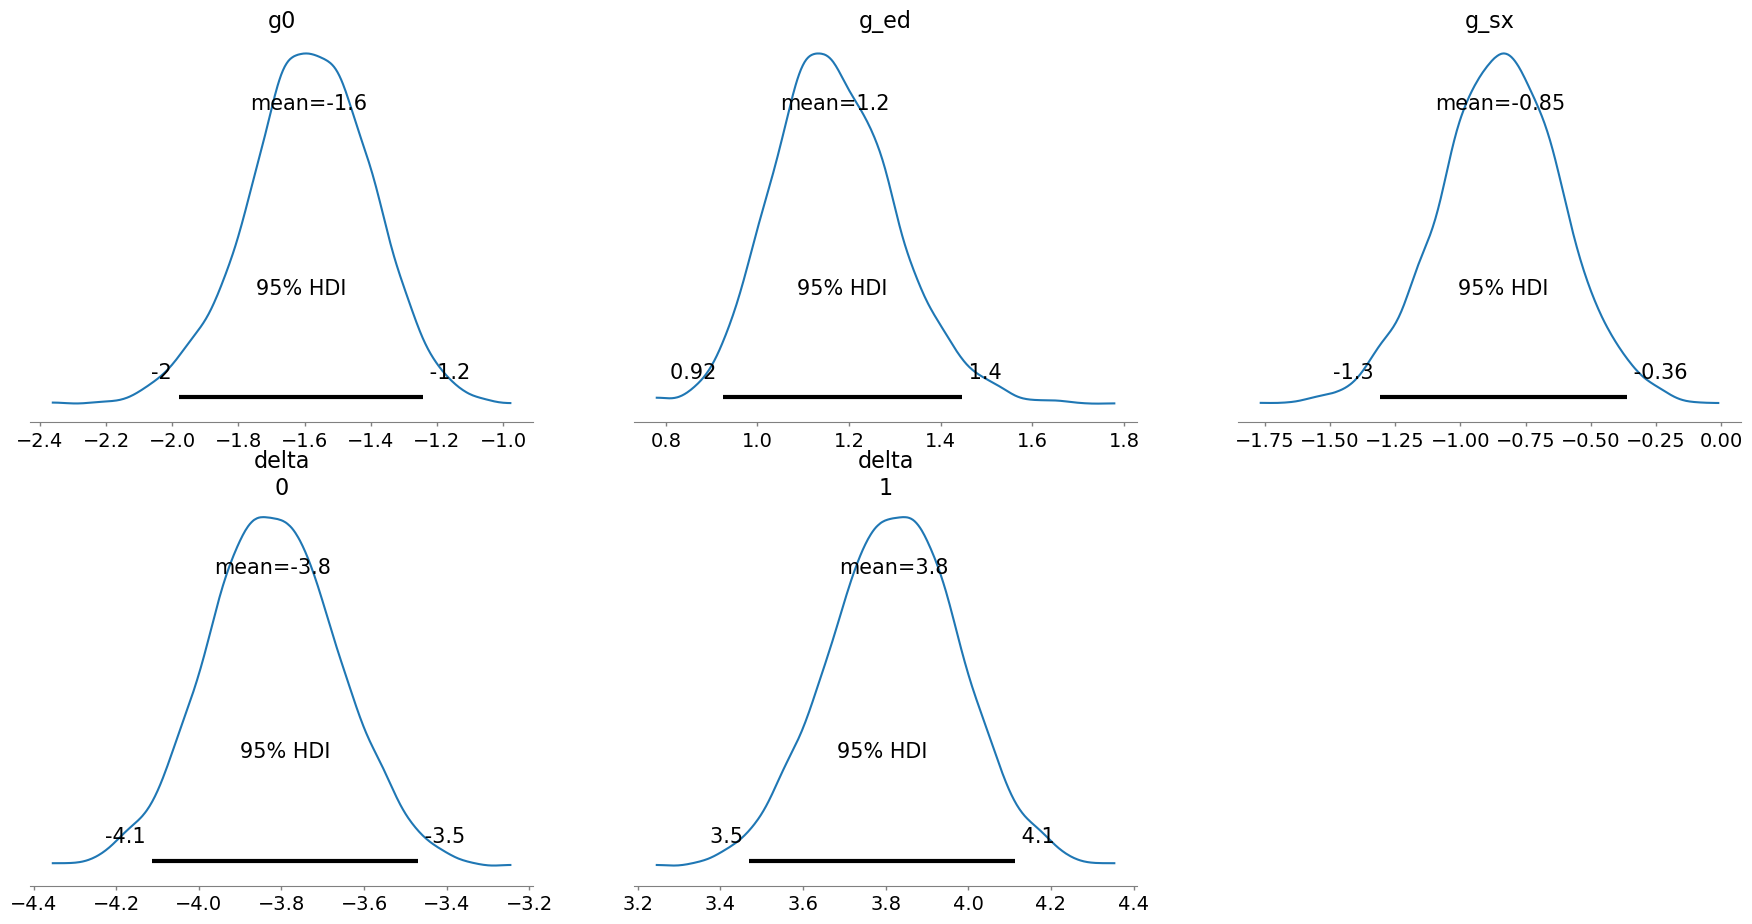

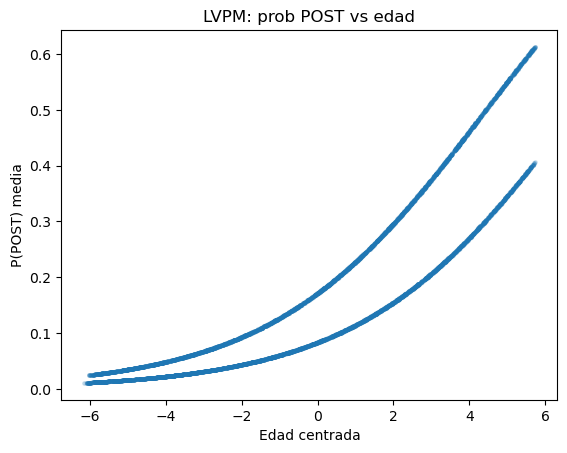

In [35]:

az.plot_posterior(idata_m6_sub, var_names=["g0","g_ed","g_sx","delta"], hdi_prob=0.95)
plt.show()

# Probabilidad media de POST por edad (rápido)
p_post_mean = idata_m6_sub.posterior["p_post"].mean(("chain","draw")).values
plt.scatter(edad_c_sub, p_post_mean, s=6, alpha=0.2)
plt.xlabel("Edad centrada"); plt.ylabel("P(POST) media"); plt.title("LVPM: prob POST vs edad")
plt.show()


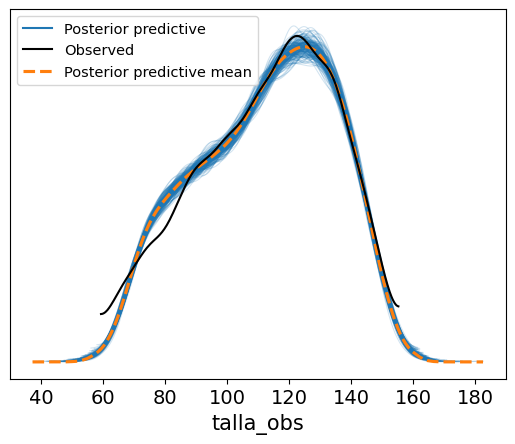

In [36]:
az.plot_ppc(idata_m6_sub, num_pp_samples=200)
plt.show()


# M6_sub no es radicalmente mejor, pero sí va en la dirección correcta.

# Corrigiendo M6

---

## Sandbox

In [22]:
df.columns.tolist()

['folio',
 'intp',
 'entidad',
 'municipio',
 'localidad',
 'sexo',
 'edad_meses',
 'edad_anios',
 'peso_kg',
 'talla_cm',
 'zscore_imc_para_edad',
 'clasificacion_imc',
 'ponderador',
 'region',
 'id_persona',
 'num_integrante',
 'edad_dias',
 'fecha_nacimiento',
 'fecha_visita',
 'altitud_localidad',
 'code_upm',
 'estrato_diseño',
 'estrato_urbanidad',
 'estrato_marginalidad',
 'estrato_varianza',
 'area_urbana_rural',
 'region_geo',
 'ageb',
 'indice_socioeconomico',
 'afiliacion_salud',
 'nivel_socioecon_decil',
 'nivel_socioecon_quintil',
 'nivel_socioecon_tercil',
 'ponderador_muestra',
 'tipo_hemocue',
 'hemoglobina_g_dl',
 'hemoglobina_ajustada_g_dl',
 'anemia',
 'folio_consecutivo',
 'munici',
 'locali',
 'edad',
 'dia_nac',
 'mes_nac',
 'anio_nac',
 'est_urb',
 'est_marg',
 'pondef',
 'folio_vivienda',
 'meses',
 'afilia_1ra',
 'afilia_tras',
 'pondei',
 'deciles',
 'pondeh',
 'grupo_edad',
 'imc',
 'edad_anios_calc']

---